# Problem Set 1: Edges and Lines
---
## Setup

In [1]:
# IPython magic
%load_ext autoreload
%autoreload 2
# Matplotlib magic
%matplotlib inline

In [2]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
# Matplotlib params
plt.rcParams['figure.figsize'] = (14.0, 6.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# Change to True if Jupyter Widgets extension is installed
IS_INTERACTIVE = False
# Turn widgets on-off
if IS_INTERACTIVE:
    from ipywidgets import interact
else:
    def interact(**kwargs):
        def decorator(f):
            return f();
        return decorator

---
## 1. Edge Operator

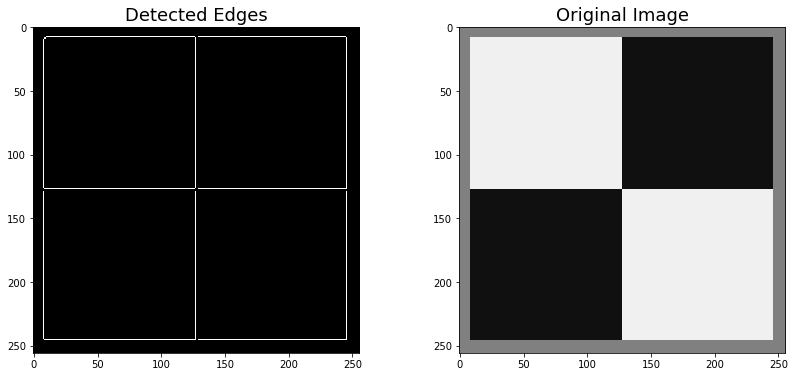

In [4]:
# Load image
img1 = cv2.imread('ps1-input0.png')
# OpenCV BGR to RGB
img1 = img1[:,:,::-1]
# Edge Detection
img1_edges = cv2.Canny(img1, 100, 200)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Detected Edges')
ax[0].imshow(img1_edges)
ax[1].set_title('Original Image')
ax[1].imshow(img1);

---
## 2. Hough Line Detector

In [5]:
class HoughLines:
    def __init__(self, img, rho_res=1.0, theta_res=np.pi/180, thresh=100):
        # Image
        self.img = img
        # Tunable params
        self.rho_res = rho_res
        self.theta_res = theta_res
        self.thresh = thresh
        # Limits
        self.rho_min = -self.img.shape[1]
        self.rho_max = np.sqrt(self.img.shape[0]**2 + self.img.shape[1]**2)
        return
    
    def accumulate(self):
        num_theta = int(round(np.pi / self.theta_res))
        num_rho = int(round((self.rho_max-self.rho_min) / self.rho_res)) + 1
        self.accum = np.zeros((num_rho, num_theta))
        for y, row in enumerate(self.img):
            for x, val in enumerate(row):
                if val > 0:
                    for theta_ix in range(num_theta):
                        theta = theta_ix * self.theta_res
                        rho = x*np.cos(theta) + y*np.sin(theta)
                        rho_ix = int(round((rho-self.rho_min) / self.rho_res))
                        self.accum[rho_ix, theta_ix] += 1
        self.lines = None
        return self.accum
    
    def extract_lines(self):
        self.lines = []
        num_rho, num_theta = self.accum.shape
        for rho_ix in range(1, num_rho-1):
            for theta_ix in range(num_theta):
                if self.accum[rho_ix, theta_ix] > self.thresh:
                    rho = self.rho_min + self.rho_res*rho_ix
                    if theta_ix == 0:
                        rho_left = int(round((-rho-self.rho_min) / self.rho_res))
                        left = self.accum[rho_left, -1]
                        right = self.accum[rho_ix, theta_ix+1]
                    elif theta_ix == num_theta-1:
                        rho_right = int(round((-rho-self.rho_min) / self.rho_res))
                        left = self.accum[rho_ix, theta_ix-1]
                        right = self.accum[rho_right, 0]
                    else:
                        left = self.accum[rho_ix, theta_ix-1]
                        right = self.accum[rho_ix, theta_ix+1]

                    if self.accum[rho_ix, theta_ix] > self.accum[rho_ix-1, theta_ix] and \
                    self.accum[rho_ix, theta_ix] >= self.accum[rho_ix+1, theta_ix] and \
                    self.accum[rho_ix, theta_ix] > left and \
                    self.accum[rho_ix, theta_ix] >= right:
                        theta = self.theta_res*theta_ix
                        self.lines.append((rho, theta))
        return self.lines
    
    def plot_accum(self, ax):
        # Accumulator
        im = ax.imshow(self.accum, aspect='auto', origin='lower', extent=[0, np.pi, self.rho_min, self.rho_max])
        # Fix x,y axes
        ax.set_ylim(self.rho_min, self.rho_max)
        ax.set_xlim(0, np.pi)
        if self.lines:
            rho, theta = zip(*self.lines)
            ax.scatter(theta, rho, s=80, facecolors='none', edgecolors='r')
        ax.set_title('Accumulator')
        # Create colorbar
        plt.colorbar(im)
        return
    
    def plot_lines(self, ax):
        # Lines
        ax.set_title('Detected Lines')
        # Fix x,y axes
        ax.set_ylim(self.img.shape[0], 0)
        ax.set_xlim(0, self.img.shape[1])
        xrange = range(self.img.shape[1])
        yrange = range(self.img.shape[0])
        # Plot each line
        for rho, theta in self.lines:
            ax.plot(*HoughLines.get_line_points(rho, theta, xrange, yrange), 'g')
        return
    
    @staticmethod
    def get_line_points(rho, theta, xrange, yrange=0):
        if np.sin(theta):
            fx = (rho - xrange*np.cos(theta)) / np.sin(theta)
            return xrange, fx
        else:
            fy = (rho - yrange*np.sin(theta)) / np.cos(theta)
            return fy, yrange

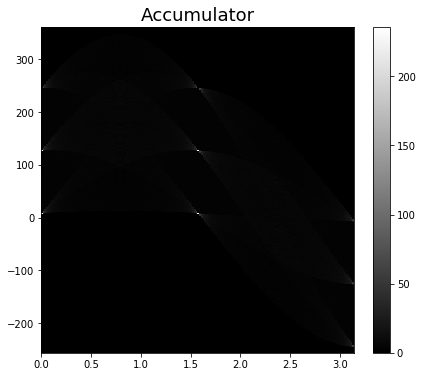

In [6]:
img1_houghobj = HoughLines(img1_edges)
@interact(rho_res=(1, 10))
def img1_hough_accum(rho_res=1):
    img1_houghobj.rho_res = rho_res
    img1_houghobj.accumulate()
    # Plot accumulator
    fig, ax = plt.subplots(figsize=(7, 6))
    img1_houghobj.plot_accum(ax)
    return

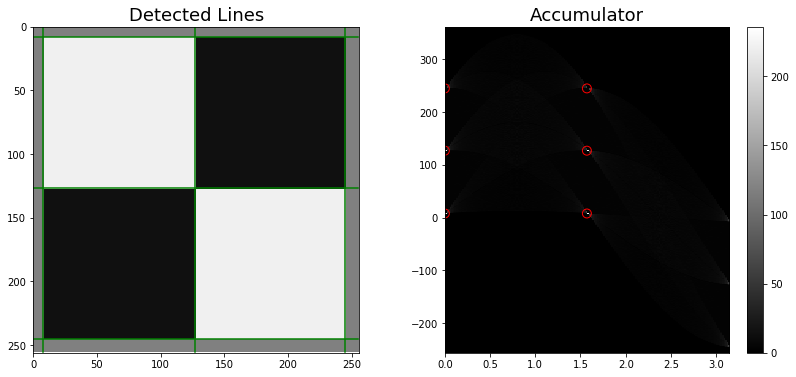

In [7]:
@interact(thresh=(100, 500))
def img1_hough(thresh=200):
    img1_houghobj.thresh = thresh
    # Get lines from accumulator matrix
    img1_houghobj.extract_lines()
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1)
    img1_houghobj.plot_lines(ax[0])    
    img1_houghobj.plot_accum(ax[1])
    return

---
## 3. Edge Detection with Noise

In [8]:
# Load Noisy image
img1n = cv2.imread('ps1-input0-noise.png')
# OpenCV BGR to RGB
img1n = img1n[:,:,::-1]

### a. Gaussian Filter

In [9]:
class GaussianFilter:
    def __init__(self, img, ksize=1, sigma=1.0):
        self.img = img
        self.kernel_size = ksize
        self.sigma = sigma
    def blur(self):
        self.img_blur = cv2.GaussianBlur(self.img, (self.kernel_size, self.kernel_size), self.sigma)
        return self.img_blur
    def plot_comparison(self):
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(self.img_blur)
        ax[0].set_title('Blurred Image')
        ax[1].imshow(self.img)
        ax[1].set_title('Original Image')
        return

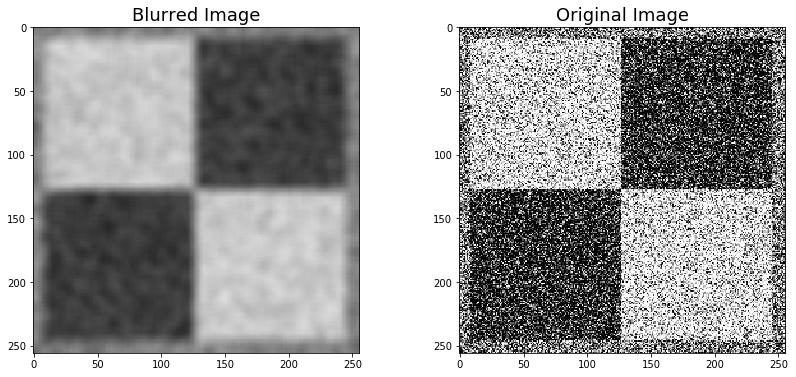

In [10]:
img1n_blurobj = GaussianFilter(img1n)
@interact(ksize=(1,25,2), sigma=(0.1,5.0,0.1))
def img1_gaussian_blur(ksize=13, sigma=4.2):
    img1n_blurobj.kernel_size = ksize
    img1n_blurobj.sigma = sigma
    # Add blur
    img1n_blurobj.blur()
    # Plot
    img1n_blurobj.plot_comparison()
    return

### b. Edge Operator

In [11]:
class CannyOperator:
    def __init__(self, img, thresh_low=100, thresh_high=200):
        self.img = img
        self.thresh_low = thresh_low
        self.thresh_high = thresh_high
    def operate(self):
        self.img_edges = cv2.Canny(self.img, self.thresh_low, self.thresh_high)
        return self.img_edges

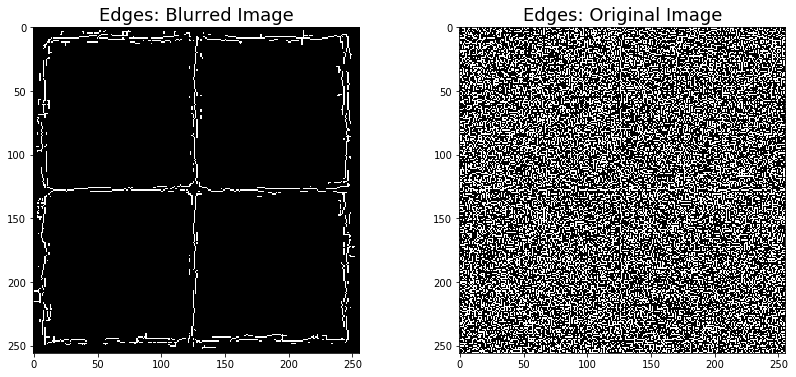

In [12]:
img1n_cannyobj = CannyOperator(img1n_blurobj.img_blur)
@interact(thresh_low=(0,255), thresh_high=(0,255))
def img1_canny(thresh_low=50, thresh_high=65):
    # Canny edge operator
    img1n_cannyobj.thresh_low = thresh_low
    img1n_cannyobj.thresh_high = thresh_high
    img1n_cannyobj.operate()
    # Edge detection on original image
    img1n_edges = cv2.Canny(img1n, 50, 65)
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1n_cannyobj.img_edges)
    ax[0].set_title('Edges: Blurred Image')
    ax[1].imshow(img1n_edges)
    ax[1].set_title('Edges: Original Image')
    return

### c. Hough Line detection

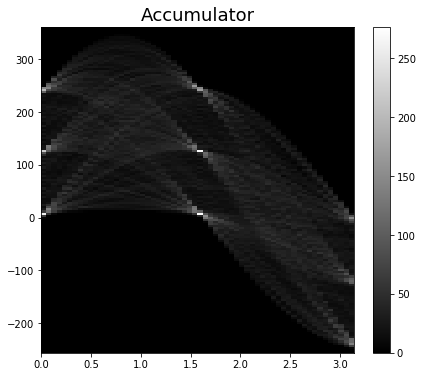

In [15]:
img1n_houghobj = HoughLines(img1n_cannyobj.img_edges)
@interact(rho_res=(1, 10), theta_res_deg=(0.5, 20.0, 0.5))
def img1n_hough_accum(rho_res=4.0, theta_res_deg=3.0):
    img1n_houghobj.rho_res = rho_res
    img1n_houghobj.theta_res = theta_res_deg * np.pi/180
    img1n_houghobj.accumulate()
    # Plot accumulator
    fig, ax = plt.subplots(figsize=(7, 6))
    img1n_houghobj.plot_accum(ax)
    return

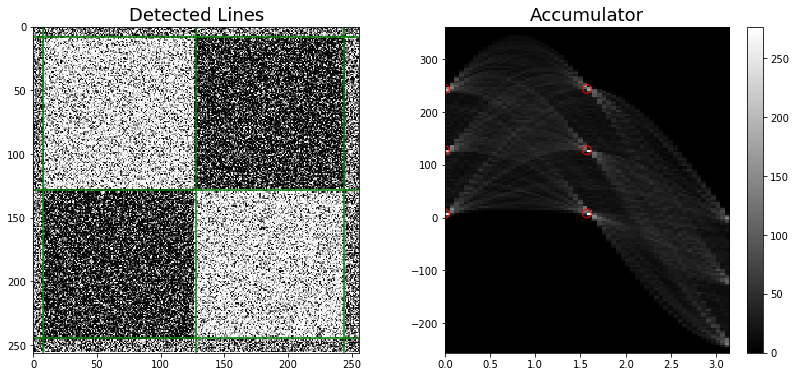

In [16]:
@interact(thresh=(50, 400))
def img1n_hough(thresh=170):
    img1n_houghobj.thresh = thresh
    # Get lines from accumulator matrix
    img1n_houghobj.extract_lines()
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1n)
    img1n_houghobj.plot_lines(ax[0])    
    img1n_houghobj.plot_accum(ax[1])
    return

---
## 4. Edge Detection: Second Image

In [17]:
# Load Noisy image
img2 = cv2.imread('ps1-input1.jpg')
# OpenCV BGR to RGB
img2 = img2[:,:,::-1]

### a. Gaussian Filter

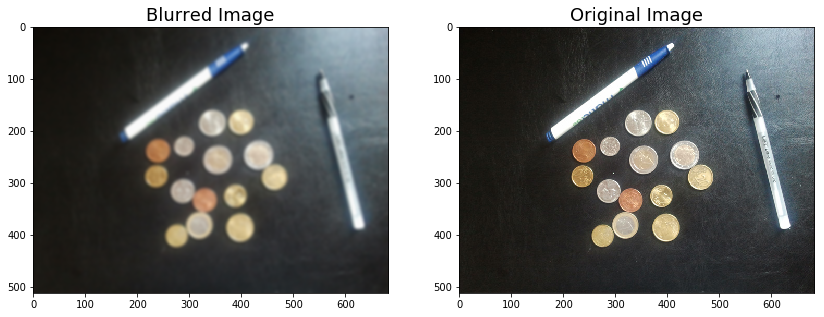

In [18]:
img2_blurobj = GaussianFilter(img2)
@interact(ksize=(1,25,2), sigma=(0.1,5.0,0.1))
def img2_gaussian_blur(ksize=11, sigma=3.0):
    img2_blurobj.kernel_size = ksize
    img2_blurobj.sigma = sigma
    # Add blur
    img2_blurobj.blur()
    # Plot
    img2_blurobj.plot_comparison()
    return

### b. Edge Operator

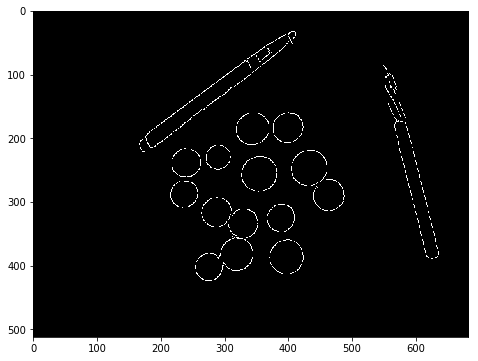

In [19]:
img2_cannyobj = CannyOperator(img2_blurobj.img_blur)
@interact(thresh_low=(0,255), thresh_high=(0,255))
def img2_canny(thresh_low=50, thresh_high=100):
    # Canny edge operator
    img2_cannyobj.thresh_low = thresh_low
    img2_cannyobj.thresh_high = thresh_high
    img2_cannyobj.operate()
    # Plot
    plt.imshow(img2_cannyobj.img_edges)
    return

### c. Hough Line detection

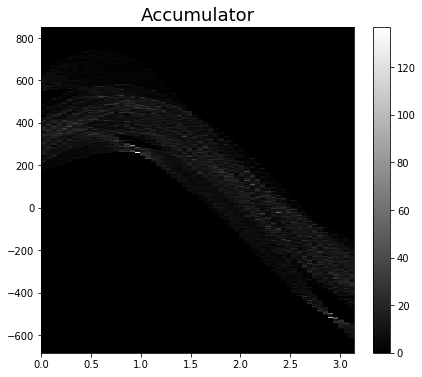

In [21]:
img2_houghobj = HoughLines(img2_cannyobj.img_edges)
@interact(rho_res=(1, 10), theta_res_deg=(0.5, 20.0, 0.5))
def img2_hough_accum(rho_res=1.0, theta_res_deg=3.0):
    img2_houghobj.rho_res = rho_res
    img2_houghobj.theta_res = theta_res_deg * np.pi/180
    img2_houghobj.accumulate()
    # Plot accumulator
    fig, ax = plt.subplots(figsize=(7, 6))
    img2_houghobj.plot_accum(ax)
    return

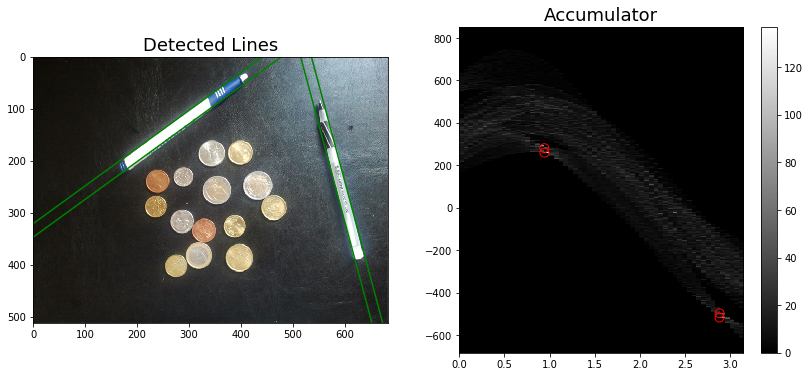

In [22]:
@interact(thresh=(50, 200))
def img2_hough(thresh=80):
    img2_houghobj.thresh = thresh
    # Get lines from accumulator matrix
    img2_houghobj.extract_lines()
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img2)
    img2_houghobj.plot_lines(ax[0])    
    img2_houghobj.plot_accum(ax[1])
    return

---
## 5. Hough Circle Detection

In [23]:
class HoughCircles:
    def __init__(self, img, r_min, r_max, r_res=1.0, xy_res=1.0, thresh=100):
        # Image
        self.img = img
        # Tunable params
        self.r_min = r_min
        self.r_max = r_max
        self.r_res = r_res
        self.xy_res = xy_res
        self.thresh = thresh
        return

    def accumulate(self):
        # Limits
        self.x_min = -self.r_max
        self.x_max = self.img.shape[1] + self.r_max
        self.y_min = -self.r_max
        self.y_max = self.img.shape[0] + self.r_max
        # Dimensions
        num_y = int(round((self.y_max-self.y_min) / self.xy_res))
        num_x = int(round((self.x_max-self.x_min) / self.xy_res))
        num_r = int(round((self.r_max-self.r_min) / self.r_res))
        self.accum = np.zeros((num_y, num_x, num_r))
        for y, row in enumerate(self.img):
            for x, val in enumerate(row):
                if val > 0:
                    for r_ix in range(num_r):
                        r = self.r_min + self.r_res*r_ix
                        for theta in np.arange(0, 2*np.pi, np.pi/180):
                            x_center = x + r*np.cos(theta)
                            y_center = y + r*np.sin(theta)

                            x_ix = int(round((x_center-self.x_min) / self.xy_res))
                            y_ix = int(round((y_center-self.y_min) / self.xy_res))

                            self.accum[y_ix, x_ix, r_ix] += 1
        self.circles = None
        return self.accum

    def extract_circles(self):
        self.circles = []
        num_y, num_x, num_r = self.accum.shape
        for y_ix in range(1, num_y-1):
            for x_ix in range(1, num_x-1):
                for r_ix in range(1, num_r-1):
                    if self.accum[y_ix, x_ix, r_ix] > self.thresh and \
                    self.accum[y_ix, x_ix, r_ix] > self.accum[y_ix-1, x_ix, r_ix] and \
                    self.accum[y_ix, x_ix, r_ix] > self.accum[y_ix+1, x_ix, r_ix] and \
                    self.accum[y_ix, x_ix, r_ix] > self.accum[y_ix, x_ix-1, r_ix] and \
                    self.accum[y_ix, x_ix, r_ix] > self.accum[y_ix, x_ix+1, r_ix] and \
                    self.accum[y_ix, x_ix, r_ix] > self.accum[y_ix, x_ix, r_ix-1] and \
                    self.accum[y_ix, x_ix, r_ix] > self.accum[y_ix, x_ix, r_ix+1]:
                        x = self.x_min + self.xy_res*x_ix
                        y = self.y_min + self.xy_res*y_ix
                        r = self.r_min + self.r_res*r_ix
                        self.circles.append((x, y, r))
        return self.circles

    def plot_accum(self, ax, r_slice_ix):
        # Accumulator
        im = ax.imshow(self.accum[:, :, r_slice_ix], extent=[self.x_min, self.x_max, self.y_min, self.y_max])
        # Fix x,y axes
        ax.set_xlim(self.x_min, self.x_max)
        ax.set_ylim(self.y_min, self.y_max)
        for x, y, r in self.circles:
            r_ix = int(round((r-self.r_min) / self.r_res))
            if r_ix == r_slice_ix:
                ax.scatter(x, y, s=80, facecolors='none', edgecolors='r')
        ax.set_title('Accumulator')
        # Create colorbar
        plt.colorbar(im)
        return

    def plot_circles(self, ax):
        ax.set_title('Detected Circles')
        # Fix x,y axes
        ax.set_ylim(self.img.shape[0], 0)
        ax.set_xlim(0, self.img.shape[1])
        # Plot each circle
        for x, y, r in self.circles:
            circ = plt.Circle((x, y), r, color='g', fill=False)
            ax.add_patch(circ)
        return

In [27]:
# Radius Limits
r_min = 15.0
r_max = 30.0
img2_houghc_obj = HoughCircles(img2_cannyobj.img_edges, r_min, r_max)

@interact(r_res=(1, 10), xy_res=(1, 10))
def img2_houghc_accum(r_res=1, xy_res=1):
    img2_houghc_obj.r_res = r_res
    img2_houghc_obj.xy_res = xy_res
    img2_houghc_obj.accumulate()
    return

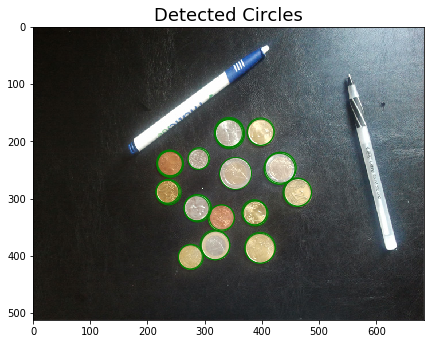

In [28]:
@interact(thresh=(100, 300))
def img2_houghc(thresh=150):
    img2_houghc_obj.thresh = thresh
    # Get circles from accumulator matrix
    img2_houghc_obj.extract_circles()
    # Plot
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.imshow(img2)
    img2_houghc_obj.plot_circles(ax)
    return

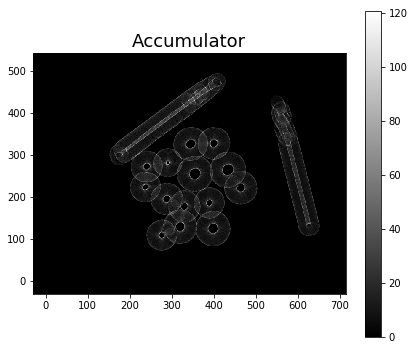

In [29]:
r_max_ix = img2_houghc_obj.accum.shape[2]-1
@interact(r_slice_ix=(0, r_max_ix))
def img2_houghc(r_slice_ix=0):
    # Plot
    fig, ax = plt.subplots(figsize=(7, 6))
    img2_houghc_obj.plot_accum(ax, r_slice_ix)
    return

---
## 6. Clutter Image

### a. Line Detection

### b. Problems

### c. Finding boundaries of pen

---
## 7. Clutter Image: Circles
### a. Hough circle detector

### b. False Alarms

---
## 8. Distorted Image

### a. Line and Circle Detection

### b. Problems

### c. Fixing Circle problem